# Predicting the Likehood of a Potential Insurance Policyholder Making a Future Claim

### Needed Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,recall_score, classification_report, confusion_matrix
import warnings
warnings.simplefilter("ignore")

### Exploratory Data Analysis (EDA)

#### 1. Aggregate Dataset 1 at the hhld_id to create the following claim count variables:

Number of At Fault claims in each of the last 5 years from application date

Number of Not At Fault claims in each of the last 5 years from application date

#### Claim_Data

In [2]:
# Read claim Data
claim_data = pd.read_excel("Claim_Data.xlsm")

In [3]:
# Parse column clm_dates to datetime
claim_data.clm_dates = pd.to_datetime(claim_data.clm_dates)

In [4]:
# Data head
claim_data.head()

hhld_id  clm_dates  aft_ind   pd_amt
0     6599 2010-12-09        1  5736.39
1     1454 2010-06-14        1  3257.49
2    13691 2011-01-08        1  8190.45
3    10347 2014-02-09        0   428.48
4     6051 2010-03-31        0   107.57

In [5]:
claim_data.shape

(5000, 4)

In [6]:
# Selecting only  claim data prior to January 1, 2017 and have atleast $1 paid out

claim_data = claim_data.loc[(claim_data["clm_dates"] < "2017-01-01")&(claim_data["pd_amt"] >= 1.0)]

In [7]:
# Selecting claim_data for the last 5years from application data

claim_data= claim_data.loc[claim_data["clm_dates"] >= "2012-01-01"]

In [8]:
# shape after filtering

claim_data.shape

(3529, 4)

In [9]:
# value count of fault claims and not at fault claims

fault_claims = claim_data.aft_ind.value_counts()
fault_claims

0    2459
1    1070
Name: aft_ind, dtype: int64

In [10]:
# check for missing values

claim_data.isnull().sum()

hhld_id      0
clm_dates    0
aft_ind      0
pd_amt       0
dtype: int64

In [11]:
# dataset information

claim_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3529 entries, 3 to 4999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   hhld_id    3529 non-null   int64         
 1   clm_dates  3529 non-null   datetime64[ns]
 2   aft_ind    3529 non-null   int64         
 3   pd_amt     3529 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 137.9 KB


In [12]:
# Statistical description of numerical data

claim_data.describe()

hhld_id      aft_ind        pd_amt
count   3529.000000  3529.000000   3529.000000
mean   10024.784642     0.303202   2469.650561
std     5780.811472     0.459707   3682.748577
min        2.000000     0.000000     26.980000
25%     5117.000000     0.000000    194.660000
50%     9983.000000     0.000000    297.970000
75%    14940.000000     1.000000   5174.610000
max    19997.000000     1.000000  19405.070000

In [13]:
# Visualizing value_counts


fig = px.pie(names = fault_claims.index,values = fault_claims.values,title="AtFault (1) /NotAtFault (0)",height=500,width=500)
fig.show()

#### Aggregated Dataset 1

In [14]:
# Group data based on required columns

agg_data = claim_data.groupby(['hhld_id', 'aft_ind']).size()
agg_data = agg_data.reset_index()

# create reqired columns and fill null values with 0


agg_data = pd.pivot(agg_data, index='hhld_id', columns="aft_ind", values=0).reset_index().fillna(0)
agg_data.columns = ["hhld_id","Not_At_Fault_claims","At_Fault_claims"]
agg_data.sample(20)

hhld_id  Not_At_Fault_claims  At_Fault_claims
809      5165                  2.0              1.0
430      2715                  1.0              0.0
1522     9396                  1.0              0.0
2674    16672                  0.0              1.0
1498     9269                  1.0              0.0
967      6016                  1.0              0.0
586      3681                  1.0              0.0
873      5518                  1.0              0.0
2754    17218                  1.0              0.0
1319     8237                  1.0              0.0
852      5400                  0.0              1.0
726      4513                  0.0              1.0
1524     9399                  0.0              1.0
2277    14133                  1.0              0.0
218      1365                  1.0              0.0
1428     8846                  1.0              0.0
1686    10458                  1.0              0.0
2987    18587                  0.0              1.0
1861    11634                  1.0              0.0
215      1360                  0.0              1.0

In [15]:
agg_data.shape

(3218, 3)

### Predictor_Dataset

In [16]:
# Reading data
predictor_data = pd.read_excel("Predictor Dataset.xlsm")

In [17]:
# Viewing data
predictor_data.head()

hhld_id  drvr_cnt  veh_cnt    min_age    hoh_age    max_age    avg_age  \
0    15937         2        1  43.789978  51.366176  51.366176  47.578077   
1    13778         1        1  35.644631  35.644631  35.644631  35.644631   
2    16063         1        1  16.000000  16.000000  16.000000  16.000000   
3    12789         1        1  17.882127  17.882127  17.882127  17.882127   
4     5122         1        1  16.000000  16.000000  16.000000  16.000000   

   min_mon_lic  hoh_mon_lic  max_mon_lic  ...  veh_lease_cnt  veh_own_cnt  \
0   333.479735   424.394117   424.394117  ...              0            0   
1   235.735566   235.735566   235.735566  ...              0            0   
2     0.000000     0.000000     0.000000  ...              0            0   
3    22.585530    22.585530    22.585530  ...              0            0   
4     0.000000     0.000000     0.000000  ...              0            0   

   monthly_pay_ind  veh_w_coll_cnt  veh_w_comp_cnt  veh_w_ers_cnt  \
0                0               1               1              1   
1                0               1               1              0   
2                0               1               1              1   
3                1               1               1              1   
4                0               0               1              1   

   curnt_bi_low  curnt_bi_upp  credit_score  zipcode  
0           100           100    825.949106    35741  
1            25            25    684.650216    87884  
2           100           100    596.318289    81525  
3           100           100    636.757859    35741  
4            50            50    669.569992    59792  

[5 rows x 41 columns]

In [18]:
print("Our predictor dataset has {} rows and {} columns. \n" .format(predictor_data.shape[0], predictor_data.shape[1]))


Our predictor dataset has 20000 rows and 41 columns. 



In [19]:
# information of data

predictor_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   hhld_id          20000 non-null  int64  
 1   drvr_cnt         20000 non-null  int64  
 2   veh_cnt          20000 non-null  int64  
 3   min_age          20000 non-null  float64
 4   hoh_age          20000 non-null  float64
 5   max_age          20000 non-null  float64
 6   avg_age          20000 non-null  float64
 7   min_mon_lic      20000 non-null  float64
 8   hoh_mon_lic      20000 non-null  float64
 9   max_mon_lic      20000 non-null  float64
 10  avg_mon_lic      20000 non-null  float64
 11  cnt_yth          20000 non-null  int64  
 12  cnt_female       20000 non-null  int64  
 13  cnt_male         20000 non-null  int64  
 14  cnt_married      20000 non-null  int64  
 15  cnt_single       20000 non-null  int64  
 16  hoh_married      20000 non-null  bool   
 17  cnt_auto    

### Subsequent_Loss_Experience Data

In [20]:
# Read Data
loss_data = pd.read_excel("Subsequent_Loss_Experience.xlsm")

In [21]:
# View data
loss_data.head()

hhld_id  premium  pd_amt  loss_ratio  future_clm_ind
0    15937    133.6     0.0         0.0               0
1    13778    145.8     0.0         0.0               0
2    16063    167.0     0.0         0.0               0
3    12789    150.3     0.0         0.0               0
4     5122    117.0     0.0         0.0               0

In [22]:
print("Our Subsequent_Loss_Experience Data has {} rows and {} columns. \n" .format(loss_data.shape[0], loss_data.shape[1]))


Our Subsequent_Loss_Experience Data has 20000 rows and 5 columns. 



In [23]:
# Information on data
loss_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   hhld_id         20000 non-null  int64  
 1   premium         20000 non-null  float64
 2   pd_amt          20000 non-null  float64
 3   loss_ratio      20000 non-null  float64
 4   future_clm_ind  20000 non-null  int64  
dtypes: float64(3), int64(2)
memory usage: 781.4 KB


### 2. Merge the Datasets 2 and 3, and the aggregated form of Dataset 1 using hhld_id

In [24]:
df = pd.merge(predictor_data, loss_data, on='hhld_id', how='outer')

In [25]:
df = pd.merge(df, agg_data, on='hhld_id', how='outer')
print("Our final dataset has {} rows and {} columns. \n" .format(df.shape[0], df.shape[1]))
df.head()

Our final dataset has 20000 rows and 47 columns. 



hhld_id  drvr_cnt  veh_cnt    min_age    hoh_age    max_age    avg_age  \
0    15937         2        1  43.789978  51.366176  51.366176  47.578077   
1    13778         1        1  35.644631  35.644631  35.644631  35.644631   
2    16063         1        1  16.000000  16.000000  16.000000  16.000000   
3    12789         1        1  17.882127  17.882127  17.882127  17.882127   
4     5122         1        1  16.000000  16.000000  16.000000  16.000000   

   min_mon_lic  hoh_mon_lic  max_mon_lic  ...  curnt_bi_low  curnt_bi_upp  \
0   333.479735   424.394117   424.394117  ...           100           100   
1   235.735566   235.735566   235.735566  ...            25            25   
2     0.000000     0.000000     0.000000  ...           100           100   
3    22.585530    22.585530    22.585530  ...           100           100   
4     0.000000     0.000000     0.000000  ...            50            50   

   credit_score  zipcode  premium  pd_amt  loss_ratio  future_clm_ind  \
0    825.949106    35741    133.6     0.0         0.0               0   
1    684.650216    87884    145.8     0.0         0.0               0   
2    596.318289    81525    167.0     0.0         0.0               0   
3    636.757859    35741    150.3     0.0         0.0               0   
4    669.569992    59792    117.0     0.0         0.0               0   

   Not_At_Fault_claims  At_Fault_claims  
0                  1.0              1.0  
1                  NaN              NaN  
2                  NaN              NaN  
3                  NaN              NaN  
4                  NaN              NaN  

[5 rows x 47 columns]

In [26]:
df.isnull().sum()

hhld_id                    0
drvr_cnt                   0
veh_cnt                    0
min_age                    0
hoh_age                    0
max_age                    0
avg_age                    0
min_mon_lic                0
hoh_mon_lic                0
max_mon_lic                0
avg_mon_lic                0
cnt_yth                    0
cnt_female                 0
cnt_male                   0
cnt_married                0
cnt_single                 0
hoh_married                0
cnt_auto                   0
cnt_mtrcyc                 0
avg_majr_viol              0
cnt_majr_viol              0
cnt_minr_viol              0
avg_minr_viol              0
cnt_lic_susp               0
curnt_insurer              0
time_w_carr             7010
inforce_ind                0
prior_bi                7010
fire_ind                   0
homeowner_ind              0
veh_lien_cnt           19974
veh_lease_cnt              0
veh_own_cnt                0
monthly_pay_ind            0
veh_w_coll_cnt

In [27]:
# for variables 'Not_At_Fault_Claims' and 'At_Fault_calims' missing values are replaced with 0

x = ['Not_At_Fault_claims', 'At_Fault_claims']
for y in x:
    df[y].fillna(0, inplace=True)

In [28]:
# dataframe information
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Data columns (total 47 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   hhld_id              20000 non-null  int64  
 1   drvr_cnt             20000 non-null  int64  
 2   veh_cnt              20000 non-null  int64  
 3   min_age              20000 non-null  float64
 4   hoh_age              20000 non-null  float64
 5   max_age              20000 non-null  float64
 6   avg_age              20000 non-null  float64
 7   min_mon_lic          20000 non-null  float64
 8   hoh_mon_lic          20000 non-null  float64
 9   max_mon_lic          20000 non-null  float64
 10  avg_mon_lic          20000 non-null  float64
 11  cnt_yth              20000 non-null  int64  
 12  cnt_female           20000 non-null  int64  
 13  cnt_male             20000 non-null  int64  
 14  cnt_married          20000 non-null  int64  
 15  cnt_single           20000 non-null 

In [29]:
# Dropping  the hhld_Id variable which is less important 

df.drop(["hhld_id"],axis=1,inplace=True)

In [30]:
# Missing values percentage (%)
# Count missing values

missing_values = df.isna().sum()

# Get percentage

missing_values= missing_values/df.shape[0] *100
missing_values

drvr_cnt                0.000
veh_cnt                 0.000
min_age                 0.000
hoh_age                 0.000
max_age                 0.000
avg_age                 0.000
min_mon_lic             0.000
hoh_mon_lic             0.000
max_mon_lic             0.000
avg_mon_lic             0.000
cnt_yth                 0.000
cnt_female              0.000
cnt_male                0.000
cnt_married             0.000
cnt_single              0.000
hoh_married             0.000
cnt_auto                0.000
cnt_mtrcyc              0.000
avg_majr_viol           0.000
cnt_majr_viol           0.000
cnt_minr_viol           0.000
avg_minr_viol           0.000
cnt_lic_susp            0.000
curnt_insurer           0.000
time_w_carr            35.050
inforce_ind             0.000
prior_bi               35.050
fire_ind                0.000
homeowner_ind           0.000
veh_lien_cnt           99.870
veh_lease_cnt           0.000
veh_own_cnt             0.000
monthly_pay_ind         0.000
veh_w_coll

### Data Visualization

In [31]:
# Bar plot for missing values per feature
px.bar(missing_values,title="Missing Percentage",color = missing_values.index)

In [32]:
# Dropped columns with over 35% missing values. 

# Imputation is used to treat missing values in credit score variable much later in our code

df.drop(["time_w_carr"],axis=1,inplace=True)
df.drop(["prior_bi"],axis=1,inplace=True)
df.drop(["veh_lien_cnt"],axis=1,inplace=True)

In [33]:
# Target Visualisation of those who had claims within the first year of being insured with StateFarm

label_cnts = df.future_clm_ind.value_counts()
print(label_cnts)
# Plot value_counts
px.pie(names = ["Didn't Had Claim", "Had Claim"],values = label_cnts.values,title="Target Visualization",height=500,width=500)

0    19131
1      869
Name: future_clm_ind, dtype: int64


In [34]:
# Insurer popularity

curnt_insurer_count = df.curnt_insurer.value_counts()
print(curnt_insurer_count)
# Plot value_counts
px.pie(names = curnt_insurer_count.index,values = curnt_insurer_count.values,title="Insurer Popularity",height=500,width=500)

MISSING            7010
OTHER              3665
GEICO              2079
ALLSTATE           1882
PROGRESSIVE        1865
FARMERS            1299
LIBERTY MUTUAL      898
NATIONWIDE          709
AMERICAN FAMILY     593
Name: curnt_insurer, dtype: int64


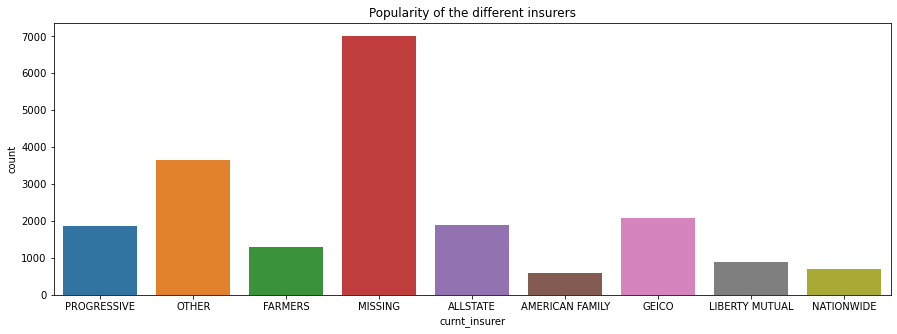

In [35]:
# Count plot of insurer popularity

plt.figure(figsize=(15, 5))
sns.countplot(df['curnt_insurer'])
plt.title('Popularity of the different insurers')
plt.xlabel('curnt_insurer')
plt.ylabel('count')
plt.show()

In [36]:
# box plot visulzing credit score for those who had claims within the first year of being insured with Statefarm

temp_data= df.dropna()
px.box(temp_data,y="credit_score", color="future_clm_ind",title="Credit Score")


In [37]:
# Age visualization

from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Initialize figure with subplots
fig = make_subplots(
    rows=2, cols=2, subplot_titles=("Minimum age of drivers in household", "Age of head of household", "Maximum age of drivers in household", "Average age of drivers in houshold")
)

# Add traces
fig.add_trace(go.Box(x=df.min_age), row=1, col=1)
fig.add_trace(go.Box(x=df.hoh_age), row=1, col=2)
fig.add_trace(go.Box(x=df.max_age), row=2, col=1)
fig.add_trace(go.Box(x=df.avg_age), row=2, col=2)

# Update xaxis properties
fig.update_xaxes(title_text="min_age", showgrid=False, row=1, col=1)
fig.update_xaxes(title_text="hoh_age", showgrid=False, row=1, col=2)
fig.update_xaxes(title_text="max_age", showgrid=False, row=2, col=1)
fig.update_xaxes(title_text="avg_age", showgrid=False, row=2, col=2)


# Update title and height
fig.update_layout(title_text="Age Visualisation", height=700)

fig.show()

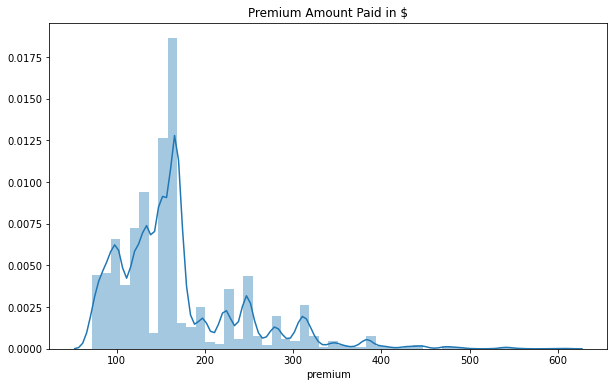

In [38]:
# Premium amount paid

plt.figure(figsize=(10,6))
plt.title("Premium Amount Paid in $")
sns.distplot(df.premium)
plt.show()

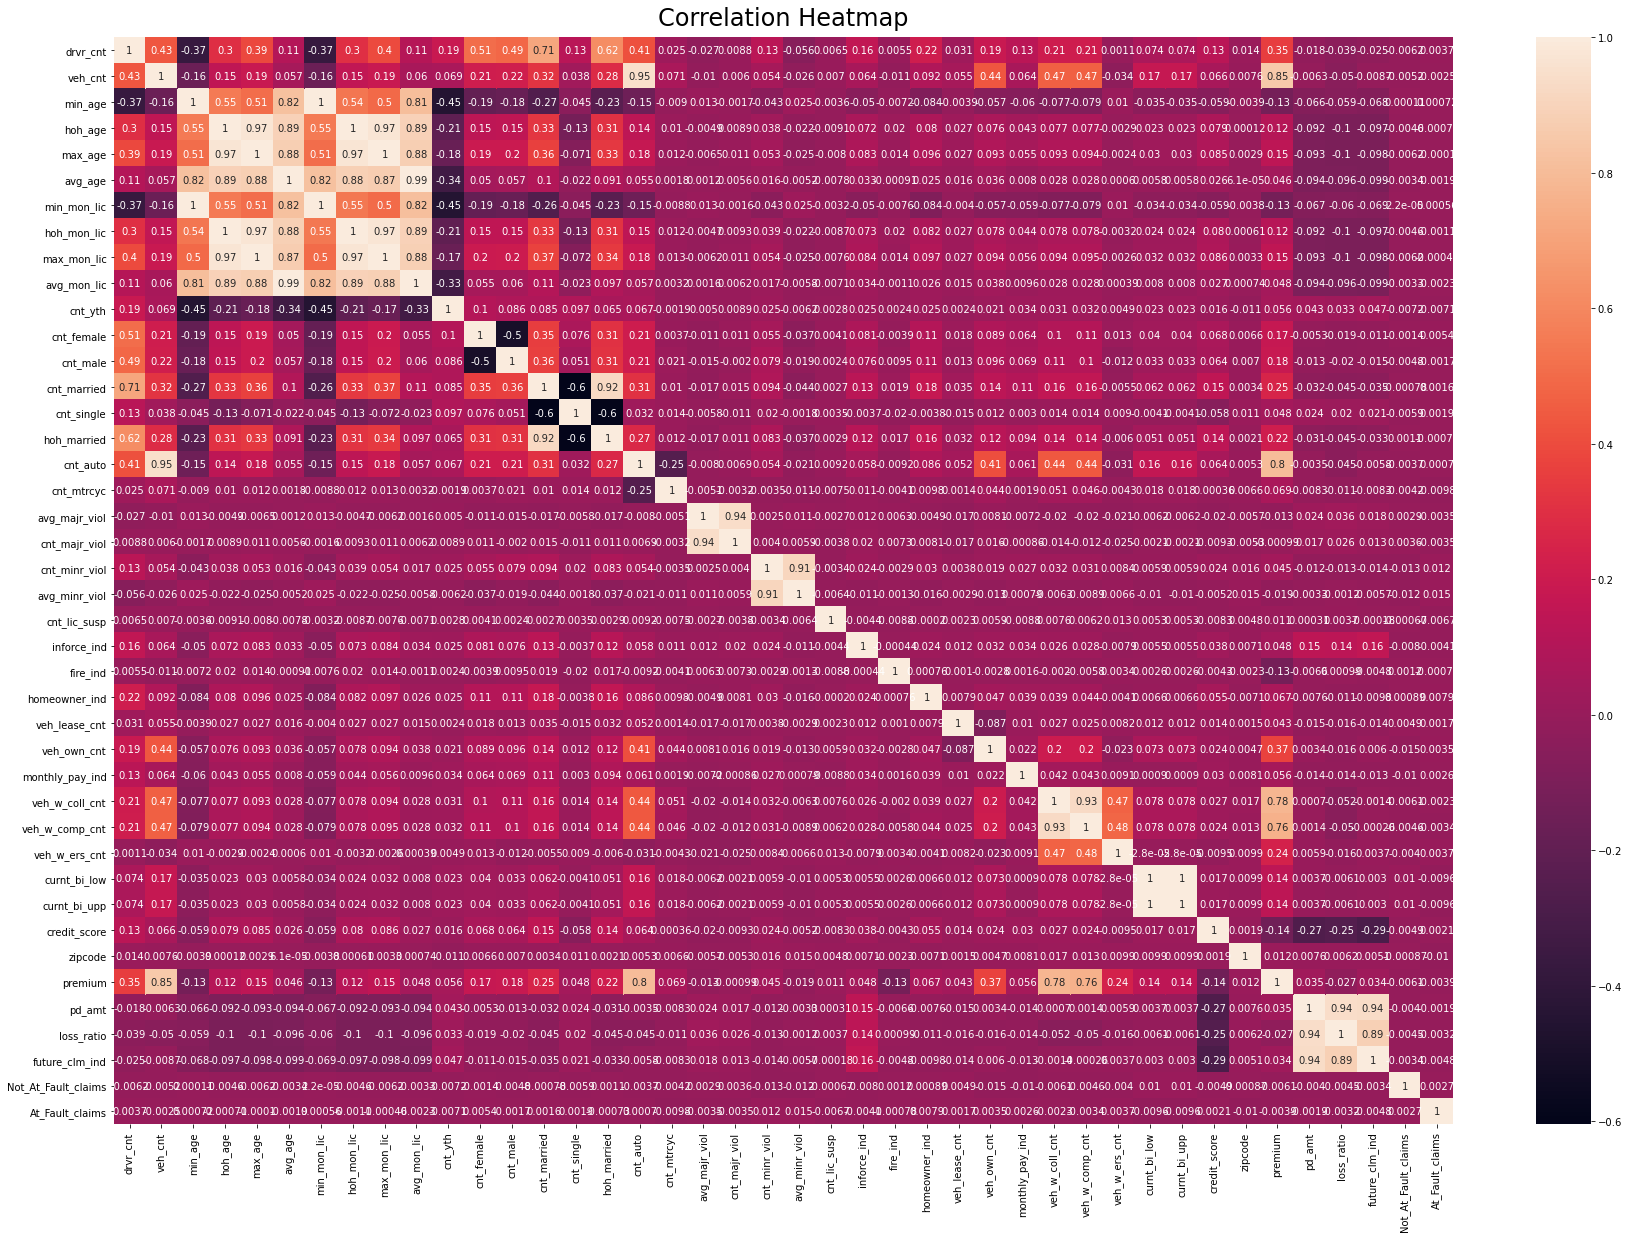

In [39]:
# Correlation 

corr= df.corr()
#heat map of correlation
plt.figure(figsize=(30,20))
sns.heatmap(corr, annot=True)
plt.title('Correlation Heatmap', fontdict={'fontsize':24}, pad=12)
plt.show()

### Data Preprocessing

It is always advisable to split data before preprocessing in order to avoid **data leakage**

In [40]:
# Splitting data into train and test data

df_train, df_test = train_test_split(df, test_size=0.2, random_state=0)

In [41]:
# Treating missing values in train and test set

# Imputation

df_train['credit_score'] = df_train['credit_score'].fillna(df_train['credit_score'].mean())
df_test['credit_score']  = df_test['credit_score'].fillna(df_test['credit_score'].mean())

In [42]:
pd.set_option('display.max_columns', None)
df_train.head()

drvr_cnt  veh_cnt    min_age    hoh_age    max_age    avg_age  \
17815         2        1  57.575016  62.889239  62.889239  60.232127   
18370         2        3  27.845852  46.388435  46.388435  37.117143   
1379          3        2  34.647265  45.926877  51.681765  44.085302   
14763         1        1  21.138936  21.138936  21.138936  21.138936   
7346          2        3  31.917496  58.090823  58.090823  45.004159   

       min_mon_lic  hoh_mon_lic  max_mon_lic  avg_mon_lic  cnt_yth  \
17815   498.900195   562.670865   562.670865   530.785530        0   
18370   142.150222   364.661217   364.661217   253.405720        0   
1379    223.767175   359.122524   428.181179   337.023626        0   
14763    61.667234    61.667234    61.667234    61.667234        0   
7346    191.009948   505.089870   505.089870   348.049909        0   

       cnt_female  cnt_male  cnt_married  cnt_single  hoh_married  cnt_auto  \
17815           1         1            1           1         True         1   
18370           0         2            2           0         True         3   
1379            0         3            2           1         True         2   
14763           1         0            0           1        False         1   
7346            0         2            1           1         True         3   

       cnt_mtrcyc  avg_majr_viol  cnt_majr_viol  cnt_minr_viol  avg_minr_viol  \
17815           0            0.0              0              2            1.0   
18370           0            0.0              0              0            0.0   
1379            0            0.0              0              0            0.0   
14763           0            0.0              0              0            0.0   
7346            0            0.0              0              0            0.0   

       cnt_lic_susp curnt_insurer  inforce_ind  fire_ind  homeowner_ind  \
17815             0   PROGRESSIVE            1         1              1   
18370             0      ALLSTATE            1         0              0   
1379              0       MISSING            0         1              1   
14763             0       MISSING            0         0              1   
7346              0       MISSING            0         1              0   

       veh_lease_cnt  veh_own_cnt  monthly_pay_ind  veh_w_coll_cnt  \
17815              0            1                0               1   
18370              0            2                1               0   
1379               0            1                0               1   
14763              0            1                1               1   
7346               0            2                0               0   

       veh_w_comp_cnt  veh_w_ers_cnt  curnt_bi_low  curnt_bi_upp  \
17815               1              1            25            25   
18370               0              0           100           100   
1379                1              1           250           250   
14763               1              1            25            25   
7346                0              0            25            25   

       credit_score  zipcode  premium  pd_amt  loss_ratio  future_clm_ind  \
17815    750.212987    52758   120.24     0.0         0.0               0   
18370    610.208877    23332   260.00     0.0         0.0               0   
1379     640.105700    83569   222.30     0.0         0.0               0   
14763    663.219110    23332   167.00     0.0         0.0               0   
7346     635.493711    14052   234.00     0.0         0.0               0   

       Not_At_Fault_claims  At_Fault_claims  
17815                  0.0              0.0  
18370                  1.0              0.0  
1379                   0.0              0.0  
14763                  0.0              0.0  
7346                   1.0              0.0

In [43]:
# Check again for missing values

df_train.isnull().sum()

drvr_cnt               0
veh_cnt                0
min_age                0
hoh_age                0
max_age                0
avg_age                0
min_mon_lic            0
hoh_mon_lic            0
max_mon_lic            0
avg_mon_lic            0
cnt_yth                0
cnt_female             0
cnt_male               0
cnt_married            0
cnt_single             0
hoh_married            0
cnt_auto               0
cnt_mtrcyc             0
avg_majr_viol          0
cnt_majr_viol          0
cnt_minr_viol          0
avg_minr_viol          0
cnt_lic_susp           0
curnt_insurer          0
inforce_ind            0
fire_ind               0
homeowner_ind          0
veh_lease_cnt          0
veh_own_cnt            0
monthly_pay_ind        0
veh_w_coll_cnt         0
veh_w_comp_cnt         0
veh_w_ers_cnt          0
curnt_bi_low           0
curnt_bi_upp           0
credit_score           0
zipcode                0
premium                0
pd_amt                 0
loss_ratio             0


In [44]:
# Separating independent variables from the target variable

y_train= df_train.pop('future_clm_ind')
X_train = df_train

y_test = df_test.pop('future_clm_ind')
X_test = df_test

In [45]:
X_train.head()

drvr_cnt  veh_cnt    min_age    hoh_age    max_age    avg_age  \
17815         2        1  57.575016  62.889239  62.889239  60.232127   
18370         2        3  27.845852  46.388435  46.388435  37.117143   
1379          3        2  34.647265  45.926877  51.681765  44.085302   
14763         1        1  21.138936  21.138936  21.138936  21.138936   
7346          2        3  31.917496  58.090823  58.090823  45.004159   

       min_mon_lic  hoh_mon_lic  max_mon_lic  avg_mon_lic  cnt_yth  \
17815   498.900195   562.670865   562.670865   530.785530        0   
18370   142.150222   364.661217   364.661217   253.405720        0   
1379    223.767175   359.122524   428.181179   337.023626        0   
14763    61.667234    61.667234    61.667234    61.667234        0   
7346    191.009948   505.089870   505.089870   348.049909        0   

       cnt_female  cnt_male  cnt_married  cnt_single  hoh_married  cnt_auto  \
17815           1         1            1           1         True         1   
18370           0         2            2           0         True         3   
1379            0         3            2           1         True         2   
14763           1         0            0           1        False         1   
7346            0         2            1           1         True         3   

       cnt_mtrcyc  avg_majr_viol  cnt_majr_viol  cnt_minr_viol  avg_minr_viol  \
17815           0            0.0              0              2            1.0   
18370           0            0.0              0              0            0.0   
1379            0            0.0              0              0            0.0   
14763           0            0.0              0              0            0.0   
7346            0            0.0              0              0            0.0   

       cnt_lic_susp curnt_insurer  inforce_ind  fire_ind  homeowner_ind  \
17815             0   PROGRESSIVE            1         1              1   
18370             0      ALLSTATE            1         0              0   
1379              0       MISSING            0         1              1   
14763             0       MISSING            0         0              1   
7346              0       MISSING            0         1              0   

       veh_lease_cnt  veh_own_cnt  monthly_pay_ind  veh_w_coll_cnt  \
17815              0            1                0               1   
18370              0            2                1               0   
1379               0            1                0               1   
14763              0            1                1               1   
7346               0            2                0               0   

       veh_w_comp_cnt  veh_w_ers_cnt  curnt_bi_low  curnt_bi_upp  \
17815               1              1            25            25   
18370               0              0           100           100   
1379                1              1           250           250   
14763               1              1            25            25   
7346                0              0            25            25   

       credit_score  zipcode  premium  pd_amt  loss_ratio  \
17815    750.212987    52758   120.24     0.0         0.0   
18370    610.208877    23332   260.00     0.0         0.0   
1379     640.105700    83569   222.30     0.0         0.0   
14763    663.219110    23332   167.00     0.0         0.0   
7346     635.493711    14052   234.00     0.0         0.0   

       Not_At_Fault_claims  At_Fault_claims  
17815                  0.0              0.0  
18370                  1.0              0.0  
1379                   0.0              0.0  
14763                  0.0              0.0  
7346                   1.0              0.0

In [46]:
# Encoding categroical variables using label encorder

from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()

categorical = ['curnt_insurer', 'hoh_married']

for feature in categorical:
    
    X_train[feature] = labelEncoder.fit_transform(X_train[feature])
    
    X_test[feature] = labelEncoder.transform(X_test[feature])

In [47]:
# Scaling 
# Normalization (MinMaxScaler)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)

X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

In [48]:
# Treating imbalance data

from imblearn.over_sampling import SMOTE

from collections import Counter

counter = Counter(y_train)

print('before smoting: ', counter)

smt = SMOTE()

X_train, y_train = smt.fit_resample(X_train, y_train)

counter = Counter(y_train)
print('After smoting: ', counter)


before smoting:  Counter({0: 15314, 1: 686})
After smoting:  Counter({0: 15314, 1: 15314})


### 3.	Create a model where you are trying to identify if the applicant had a future loss (future_clm_ind) using the information known on or before the application date.

## Model Implementation and Evaluation 

In [49]:
index = ["LogisticRegression", "DecisionTreeClassifier", "GradientBoostingClassifier", "RandomForestClassifier"]
results = pd.DataFrame(columns=['Accuracy','Precison','Recall', 'f1_score', 'AUC'],index=index)

### Logistic Regression

Logistic regression is a linear model for classification. It is simple to implement, efficient and fast.

In [50]:
LR = LogisticRegression()

#  Training model

LR.fit(X_train, y_train)

LogisticRegression()

In [51]:
# Making predictions

y_pred1= LR.predict(X_test)

print(y_pred1)

[0 0 0 ... 0 0 0]


In [52]:
#  Check for overfitting or underfitting

train_acc = LR.score(X_train, y_train)*100
test_acc = LR.score(X_test, y_test)*100

print("Accuracy on training set: {:.3f}%. \n".format(train_acc))
print("Accuracy on test set: {:.3f}%. \n".format(test_acc))


Accuracy on training set: 99.990%. 

Accuracy on test set: 99.950%. 



In [53]:
# Confusion Matrix

cm = confusion_matrix(y_test, y_pred1)
cm

array([[3817,    0],
       [   2,  181]], dtype=int64)

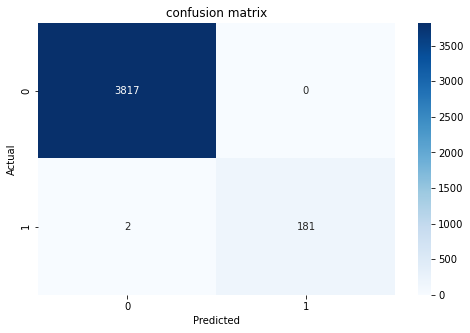

In [54]:
# Heatmap

plt.figure(figsize=(8, 5))
sns.heatmap(cm, cmap= 'Blues', linecolor='black', fmt='', annot=True)
plt.title('confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [55]:
#  Model evaluation on test set (recall, precision, accuracy, f1_score)


from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score

print('Recall: ', recall_score(y_test, y_pred1))
print('Precision: ', precision_score(y_test, y_pred1))
print('Accuracy: ', accuracy_score(y_test, y_pred1))
print('f1-score: ', f1_score(y_test, y_pred1))

Recall:  0.9890710382513661
Precision:  1.0
Accuracy:  0.9995
f1-score:  0.9945054945054945


0.9999770941330917


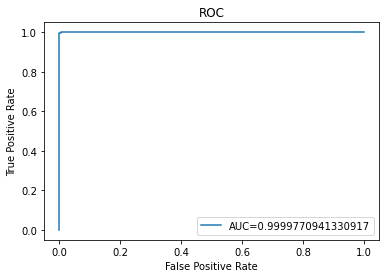

In [56]:
# ROC curve, AUC

from sklearn import metrics

y_pred_proba = LR.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

auc = metrics.roc_auc_score(y_test, y_pred_proba)
print(auc)

#create ROC curve

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC')
plt.legend(loc=4)
plt.show()


In [57]:
# Classification report

print("Classification Report: \n",classification_report(y_test, y_pred1)) 
print()

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3817
           1       1.00      0.99      0.99       183

    accuracy                           1.00      4000
   macro avg       1.00      0.99      1.00      4000
weighted avg       1.00      1.00      1.00      4000




### Decision Tree Classifier

Decision trees are a widely used model for classification and regression problems. A decision tree is made up of the decision node and leaf node. Decision nodes are used to make any decision and have multiple branches, whereas Leaf nodes are the output of those decisions and do not contain any further branches.

In [58]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()

#  Training the model

DT.fit(X_train, y_train)

DecisionTreeClassifier()

In [59]:
 #  Making predictions on test set
    
y_pred2= DT.predict(X_test)

print(y_pred2)

# Checking model for overfitiing and underfitting

print(" Accuracy on training set:", DT.score( X_train, y_train)) 

print(" Accuracy on test set:",  DT.score( X_test, y_test))

[0 0 0 ... 0 0 0]
 Accuracy on training set: 1.0
 Accuracy on test set: 1.0


In [60]:
# Confusion Matrix

cm = confusion_matrix(y_test, y_pred2)
cm

array([[3817,    0],
       [   0,  183]], dtype=int64)

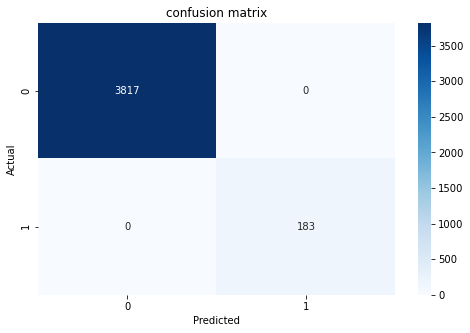

In [61]:
# Heatmap

plt.figure(figsize=(8, 5))
sns.heatmap(cm, cmap= 'Blues', linecolor='black', fmt='', annot=True)
plt.title('confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [62]:
#  Evaluating performance of moddel on test set (recall, precision, accuracy and  f1_score)

print('Recall: ', recall_score(y_test, y_pred2))
print('Precision: ', precision_score(y_test, y_pred2))
print('Accuracy: ', accuracy_score(y_test, y_pred2))
print('f1-score: ', f1_score(y_test, y_pred2))

Recall:  1.0
Precision:  1.0
Accuracy:  1.0
f1-score:  1.0


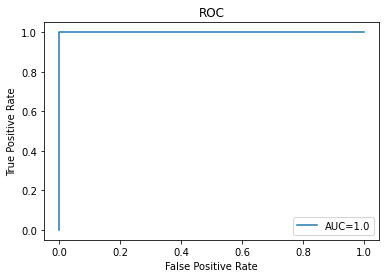

In [63]:
# ROC Curve, AUC

y_pred_proba = DT.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC')
plt.legend(loc=4)
plt.show()

In [64]:
# Classification report

print("Classification Report: \n",classification_report(y_test, y_pred2)) 
print()

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3817
           1       1.00      1.00      1.00       183

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000




### Gradient Boosting Machines

Gradient boosting machines is an ensemble method that combines multiple decision trees to create a more powerful model. Despite the “regression” in the name, these models can be used for regression and classification.


In [65]:
from sklearn.ensemble import GradientBoostingClassifier

gbrt = GradientBoostingClassifier( random_state = 0) 


In [66]:
#  Training model

gbrt.fit(X_train, y_train)

GradientBoostingClassifier(random_state=0)

In [67]:
# Prediction on the test set

y_pred3= gbrt.predict(X_test)
print(y_pred3)

[0 0 0 ... 0 0 0]


In [68]:
# Check for overfitiing or underfitting

print(" Accuracy on training set:", gbrt.score( X_train, y_train)) 

print(" Accuracy on test set:",  gbrt.score( X_test, y_test))

 Accuracy on training set: 1.0
 Accuracy on test set: 0.99975


In [69]:
# Confusion Matrix

cm = confusion_matrix(y_test, y_pred3)
cm

array([[3817,    0],
       [   1,  182]], dtype=int64)

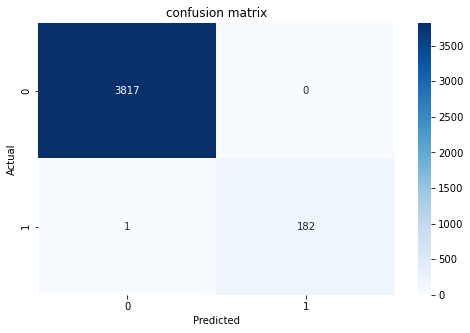

In [70]:
# Heatmap

plt.figure(figsize=(8, 5))
sns.heatmap(cm, cmap= 'Blues', linecolor='black', fmt='', annot=True)
plt.title('confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [71]:
# Model evaluation on test set (recall, precision, accuracy, f1_score, AUC)

print('Recall: ', recall_score(y_test, y_pred3))
print('Precision: ', precision_score(y_test, y_pred3))
print('Accuracy: ', accuracy_score(y_test, y_pred3))
print('f1-score: ', f1_score(y_test, y_pred3))

Recall:  0.994535519125683
Precision:  1.0
Accuracy:  0.99975
f1-score:  0.9972602739726028


1.0


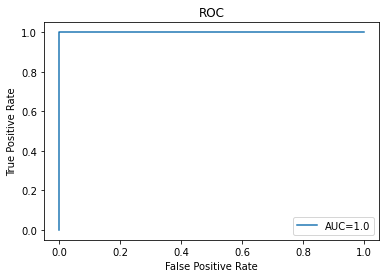

In [72]:

# ROC Curve, AUC
y_pred_proba = gbrt.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print(auc)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC')
plt.legend(loc=4)
plt.show()

In [73]:
# Classification report

print("Classification Report: \n",classification_report(y_test, y_pred3)) 
print()

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3817
           1       1.00      0.99      1.00       183

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000




### Random Forest 

A random forest is essentially a collection of decision trees, where each tree is slightly different from the others. The idea behind random forests is that each tree might do a relatively good job of predicting, but will likely overfit on part of the data. If we build many trees, all of which work well and overfit in different ways, we can reduce the amount of overfitting by averaging their results.

In [74]:
from sklearn.ensemble import RandomForestClassifier


RF = RandomForestClassifier(random_state=0)

In [75]:
# fitiing train set

RF.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [76]:
# Prediction

y_pred4 = RF.predict(X_test)

In [77]:
# Checking model for overfitiing and underfitting

print(" Accuracy on training set:", RF.score( X_train, y_train)) 

print(" Accuracy on test set:",  RF.score( X_test, y_test))


 Accuracy on training set: 1.0
 Accuracy on test set: 0.99975


In [78]:
# Confusion Matrix

cm = confusion_matrix(y_test, y_pred4)
cm

array([[3817,    0],
       [   1,  182]], dtype=int64)

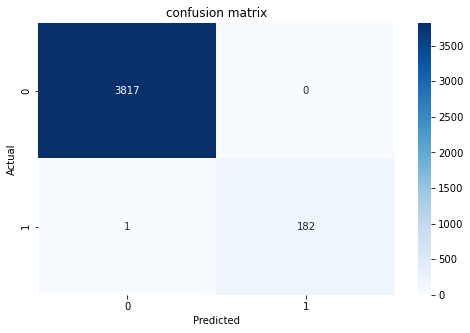

In [79]:
# Heatmap

plt.figure(figsize=(8, 5))
sns.heatmap(cm, cmap= 'Blues', linecolor='black', fmt='', annot=True)
plt.title('confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [80]:
#  Evaluating performance of moddel on test set (recall, precision, accuracy and  f1_score)

print('Recall: ', recall_score(y_test, y_pred4))
print('Precision: ', precision_score(y_test, y_pred4))
print('Accuracy: ', accuracy_score(y_test, y_pred4))
print('f1-score: ', f1_score(y_test, y_pred4))

Recall:  0.994535519125683
Precision:  1.0
Accuracy:  0.99975
f1-score:  0.9972602739726028


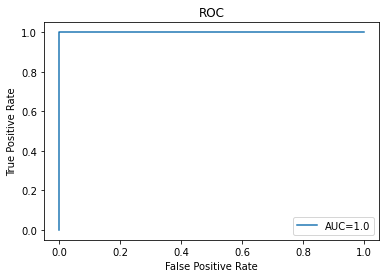

In [81]:

# ROC Curve and AUC
y_pred_proba = RF.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC')
plt.legend(loc=4)
plt.show()

In [82]:
# Classification report

print("Classification Report: \n",classification_report(y_test, y_pred4)) 
print()

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3817
           1       1.00      0.99      1.00       183

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000




All the models perform well with little or no parameter tuning or feature selection. 

We will now perform parameter tuning and  re-evaluate the model again.

### Paramter Tuning and Feature Selection

### Logistic Regression with L1 regularization

In [83]:
# Perform GridSearchCV to tune best-fit LR model

param = {'C': [10**-2,10**-1,10**0,10**1,10**2]}

lr_model = LogisticRegression(penalty='l1', solver='liblinear')
gs_model = GridSearchCV(estimator=lr_model, param_grid=param)
gs_model.fit(X_train, y_train)

# Training LR model with best parameters


model = LogisticRegression(**gs_model.best_params_, penalty='l1', solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(C=1, penalty='l1', solver='liblinear')

In [84]:
# Predictions

y_pred5= model.predict(X_test)

print(y_pred5)

# Check for overfitiing or underfitting

train_acc = model.score(X_train, y_train)*100
test_acc = model.score(X_test, y_test)*100

print("Accuracy on training set: {:.3f}%. \n".format(train_acc))
print("Accuracy on test set: {:.3f}%. \n".format(test_acc))

[0 0 0 ... 0 0 0]
Accuracy on training set: 100.000%. 

Accuracy on test set: 99.950%. 



In [85]:
# Evaluating performance of our model

rec = recall_score(y_test, y_pred5)
pre = precision_score(y_test, y_pred5)
acc = accuracy_score(y_test, y_pred5)
f1_sc =  f1_score(y_test, y_pred5)

print("Accuracy :: ",acc)
print("Precision :: ",pre)
print("Recall :: ", rec)
print("f1_score", f1_sc)



Accuracy ::  0.9995
Precision ::  1.0
Recall ::  0.9890710382513661
f1_score 0.9945054945054945


In [86]:
# Confusion matrix

cm = confusion_matrix(y_test, y_pred5)
cm

array([[3817,    0],
       [   2,  181]], dtype=int64)

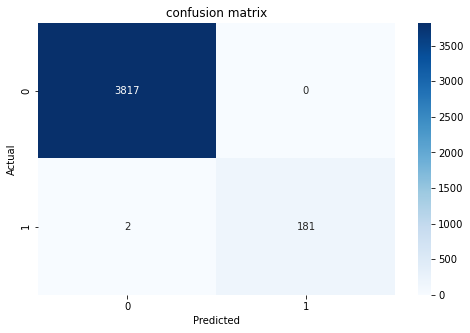

In [87]:
# Heatmap

plt.figure(figsize=(8, 5))
sns.heatmap(cm, cmap= 'Blues', linecolor='black', fmt='', annot=True)
plt.title('confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

auc:  1.0


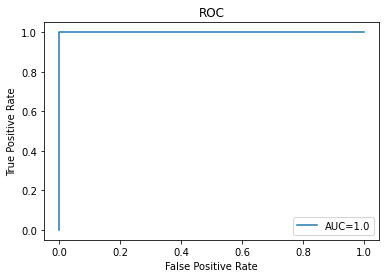

In [88]:
# ROC Curve, AUC

y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print('auc: ', auc)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC')
plt.legend(loc=4)
plt.show()

In [89]:
# Classification report

print("Classification Report: \n",classification_report(y_test, y_pred5)) 
print()

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3817
           1       1.00      0.99      0.99       183

    accuracy                           1.00      4000
   macro avg       1.00      0.99      1.00      4000
weighted avg       1.00      1.00      1.00      4000




In [90]:
results.loc["LogisticRegression"] = [acc,pre,rec, f1_sc, auc]

### Tuning a decision tree   (Pre-pruning)

In order to avoid having a pure leaf which could lead to overfitting, prepruning is usually applied. This helps in limiting the number of questions asked or branch nodes created. If we don’t restrict the depth of a decision tree, the tree can become arbitrarily deep and complex. Unpruned trees are therefore prone to overfitting and not generalizing well to new data.

In [91]:
tree = DecisionTreeClassifier(max_depth=4, random_state=7) 

# Fitting model to train set

tree.fit( X_train, y_train) 

# Checking for overfitting and underfitting

print(" Accuracy on training set: ",  tree.score( X_train, y_train)) 

print(" Accuracy on test set: ", tree.score( X_test, y_test))

 Accuracy on training set:  1.0
 Accuracy on test set:  1.0


In [92]:
# Prediction on test set

y_pred6 = tree.predict(X_test)
print(y_pred6)

[0 0 0 ... 0 0 0]


In [93]:
cm = confusion_matrix(y_test, y_pred6)
cm

array([[3817,    0],
       [   0,  183]], dtype=int64)

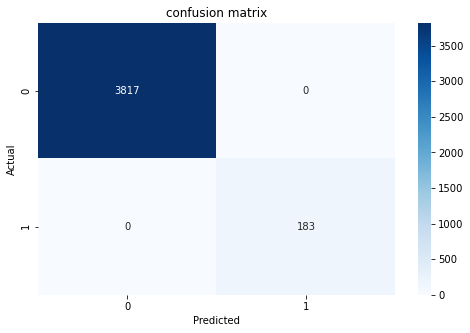

In [94]:
# Heatmap

plt.figure(figsize=(8, 5))
sns.heatmap(cm, cmap= 'Blues', linecolor='black', fmt='', annot=True)
plt.title('confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [95]:
# Evaluating model performance

rec = recall_score(y_test, y_pred6)
pre = precision_score(y_test, y_pred6)
acc = accuracy_score(y_test, y_pred6)
f1_sc =  f1_score(y_test, y_pred6)

print("Accuracy :: ",acc)
print("Precision :: ",pre)
print("Recall :: ", rec)
print("f1_score", f1_sc)



Accuracy ::  1.0
Precision ::  1.0
Recall ::  1.0
f1_score 1.0


auc:  1.0


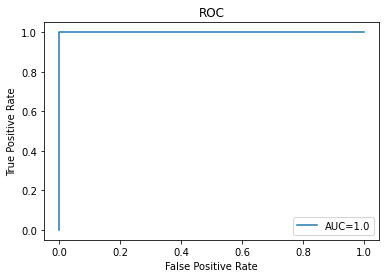

In [96]:
# ROC Curve, AUC

y_pred_proba = tree.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print('auc: ', auc)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC')
plt.legend(loc=4)
plt.show()

In [97]:
# Classification report

print("Classification Report: \n",classification_report(y_test, y_pred6)) 
print()

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3817
           1       1.00      1.00      1.00       183

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000




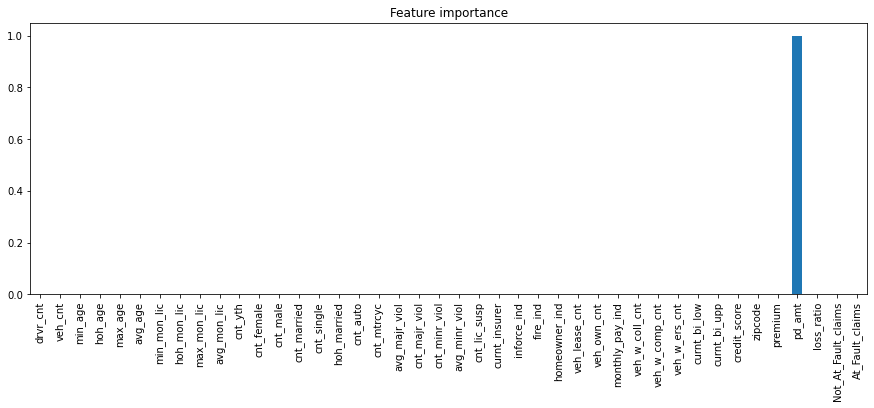

In [98]:
# visualizing the most important features

plt.figure(figsize=(15, 5))
importances = tree.feature_importances_
feature_importance = pd.Series(importances, index = X_train.columns)
feature_importance.plot(kind='bar')
plt.title('Feature importance')
plt.show()

In [99]:
results.loc["DecisionTreeClassifier"] = [acc,pre,rec, f1_sc, auc]

### Tuning gradient boosting classifier

With gradient boosting classifier we can tune our model by adjusting the learning rate as well as the max depth

In [100]:
gbrt = GradientBoostingClassifier( random_state = 0, max_depth=3, learning_rate = 0.01)

gbrt.fit( X_train, y_train) 

print(" Accuracy on training set: ", gbrt.score( X_train, y_train))

print(" Accuracy on test set: ", gbrt.score( X_test, y_test))



 Accuracy on training set:  1.0
 Accuracy on test set:  1.0


In [101]:
#  Prediction 

y_pred7 = gbrt.predict(X_test)

In [102]:
# Confusion Matrix

cm = confusion_matrix(y_test, y_pred7)
cm

array([[3817,    0],
       [   0,  183]], dtype=int64)

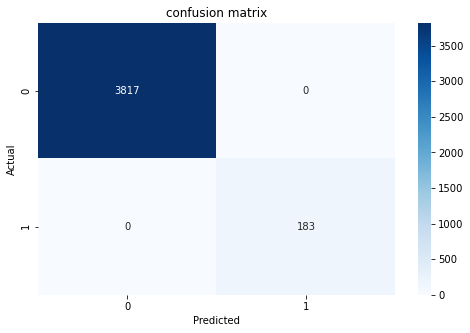

In [103]:
# Heatmap

plt.figure(figsize=(8, 5))
sns.heatmap(cm, cmap= 'Blues', linecolor='black', fmt='', annot=True)
plt.title('confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [104]:
# Re- evaluating the performance of our model

rec = recall_score(y_test, y_pred7)
pre = precision_score(y_test, y_pred7)
acc = accuracy_score(y_test, y_pred7)
f1_sc =  f1_score(y_test, y_pred7)

print("Accuracy :: ",acc)
print("Precision :: ",pre)
print("Recall :: ", rec)
print("f1_score", f1_sc)




Accuracy ::  1.0
Precision ::  1.0
Recall ::  1.0
f1_score 1.0


1.0


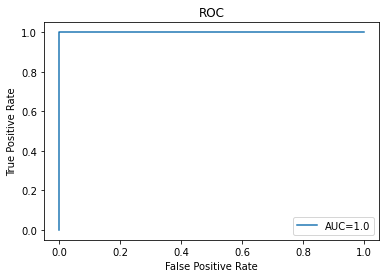

In [105]:
# ROC curve and  AUC

y_pred_proba = gbrt.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print(auc)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC')
plt.legend(loc=4)
plt.show()

In [106]:
# Classification report

print("Classification Report: \n",classification_report(y_test, y_pred7)) 
print()

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3817
           1       1.00      1.00      1.00       183

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000




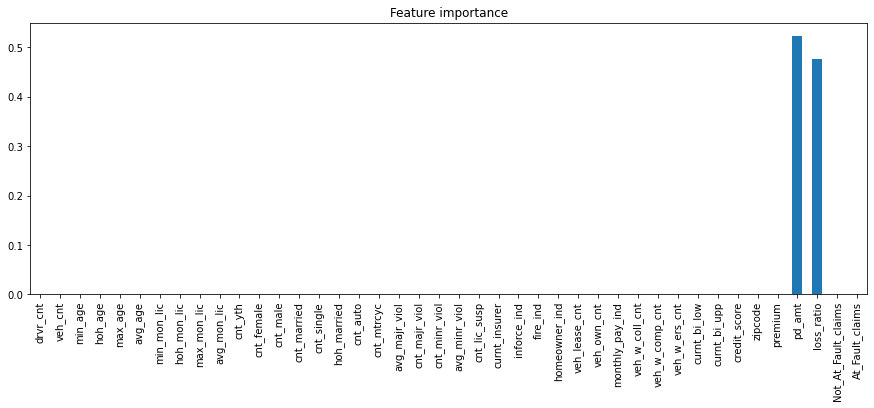

In [107]:
# visualizing the most important features

plt.figure(figsize=(15, 5))
importances = gbrt.feature_importances_
feature_importance = pd.Series(importances, index = X_train.columns)
feature_importance.plot(kind='bar')
plt.title('Feature importance')
plt.show()

In [108]:
results.loc["GradientBoostingClassifier"] = [acc,pre,rec, f1_sc, auc]

### Tuning Random Forest

In [109]:
from sklearn.ensemble import RandomForestClassifier


RF = RandomForestClassifier(n_estimators=5, max_depth=1, random_state=0)

In [110]:
# fitiing train set

RF.fit(X_train, y_train)

RandomForestClassifier(max_depth=1, n_estimators=5, random_state=0)

In [111]:
# Checking model for overfitiing and underfitting

print(" Accuracy on training set:", RF.score( X_train, y_train)) 

print(" Accuracy on test set:",  RF.score( X_test, y_test))

 Accuracy on training set: 1.0
 Accuracy on test set: 1.0


In [112]:
# Prediction

y_pred8 = RF.predict(X_test)
y_pred8

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [113]:
# Confusion Matrix

cm = confusion_matrix(y_test, y_pred8)
cm

array([[3817,    0],
       [   0,  183]], dtype=int64)

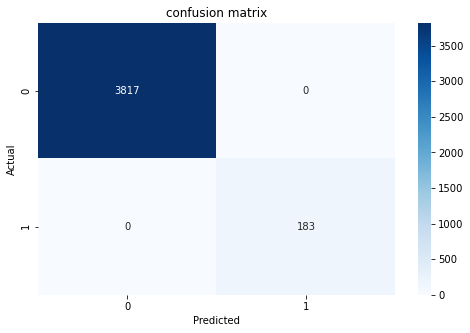

In [114]:
# Heatmap

plt.figure(figsize=(8, 5))
sns.heatmap(cm, cmap= 'Blues', linecolor='black', fmt='', annot=True)
plt.title('confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [115]:
#  Evaluating performance of the moddel on test set (recall, precision, accuracy and  f1_score)

print('Recall: ', recall_score(y_test, y_pred8))
print('Precision: ', precision_score(y_test, y_pred8))
print('Accuracy: ', accuracy_score(y_test, y_pred8))
print('f1-score: ', f1_score(y_test, y_pred8))

Recall:  1.0
Precision:  1.0
Accuracy:  1.0
f1-score:  1.0


1.0


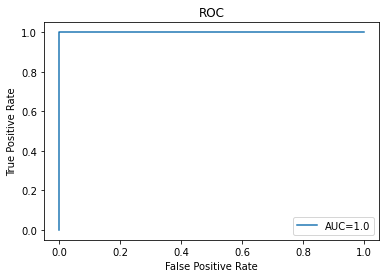

In [116]:
# ROC Curve and AUC

y_pred_proba = RF.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print(auc)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC')
plt.legend(loc=4)
plt.show()

In [117]:
# Classification report

print("Classification Report: \n",classification_report(y_test, y_pred8)) 
print()

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3817
           1       1.00      1.00      1.00       183

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000




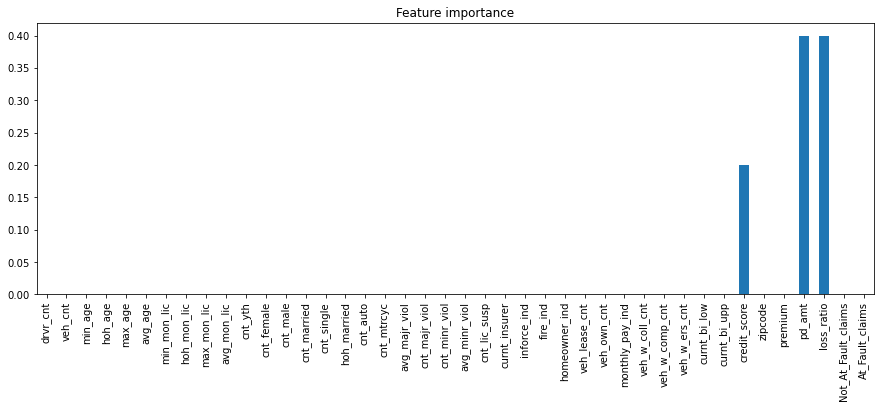

In [118]:
plt.figure(figsize=(15, 5))
importances = RF.feature_importances_
feature_importance = pd.Series(importances, index = X_train.columns)
feature_importance.plot(kind='bar')
plt.title('Feature importance')
plt.show()

In [119]:
results.loc["RandomForestClassifier"] = [acc,pre,rec, f1_sc, auc]

###  Comparing the different models

In [120]:
results = results*100
results

Accuracy Precison   Recall f1_score  AUC
LogisticRegression            99.95      100  98.9071  99.4505  100
DecisionTreeClassifier          100      100      100      100  100
GradientBoostingClassifier      100      100      100      100  100
RandomForestClassifier          100      100      100      100  100

In [121]:
px.bar(results,y ="Accuracy",x = results.index,color = results.index,title="Accuracy Comparison")

In [122]:
px.bar(results,y ="Precison",x = results.index,color = results.index,title="Precision Comparison")

In [123]:
px.bar(results,y ="Recall",x = results.index,color = results.index,title="Recall Comparison")

In [124]:
px.bar(results,y ="f1_score",x = results.index,color = results.index,title="f1_score comparison")

In [125]:
px.bar(results,y ="AUC",x = results.index,color = results.index,title="AUC Comparison")

### Conclusion

All the models performed extremely well. I will choose random forest because they are among the most widely used machine learning methods. They are immensely powerful, often work well without heavy tuning of the parameters, and do not require scaling of the data.

**Please see more explanation of the different models in the word document write up**